# 1. 把底模safetensors转化为文件夹权重模式

In [ ]:
from diffusers import StableDiffusionPipeline

checkpoint_path = r"F:\Projects\diffusers\ProgramData\tmndMix_tmndMixSPRAINBOW.safetensors"
save_path = r"F:\Projects\diffusers\ProgramData\basemodel"
# 加载 .safetensors 文件
pipeline = StableDiffusionPipeline.from_single_file(checkpoint_path)

# 将模型保存为 diffusers 格式
pipeline.save_pretrained(save_path)

# 2. 把数据集解压

In [ ]:
!apt-get install unrar
!unrar x /content/drive/MyDrive/pic.rar -o+ /content/

# 3. 训练

在train_colab.py里面改路径

sys.path.append(r'F:\Projects\diffusers\Project\PoseCtrl')

sys.path.append(r'F:\Projects\diffusers\Project\PoseCtrl\poseCtrl')




训练：
python train_colab.py --pretrained_model_name_or_path 底模路径 --base_point_path 原始点路径 --data_root_path 数据集路径 --learning_rate 学习率 --save_steps 权重保留步数 

# 4. 把模型大权重转化为训练部分小权重model.safetensors

In [ ]:
""" V0 """
import torch
import torch
from pathlib import Path
def change_checkpoint(checkpoint_path, new_checkpoint_path):
    sd = torch.load(checkpoint_path, map_location="cpu")
    vpmatrix_points_sd = {}
    atten_sd = {}
    proj_sd={}
    for k in sd:
        if k.startswith("unet"):
            pass
        elif k.startswith("vpmatrix_points"):
            vpmatrix_points_sd[k.replace("vpmatrix_points.", "")] = sd[k]
        elif k.startswith("atten_modules"):
            atten_sd[k.replace("atten_modules.", "")] = sd[k]
        elif k.startswith("image_proj_model"):
            proj_sd[k.replace("image_proj_model.", "")] = sd[k]
    new_checkpoint_path = Path(new_checkpoint_path, "posectrl.bin")
    torch.save({"vpmatrix_points": vpmatrix_points_sd, "atten_modules": atten_sd, "image_proj_model": proj_sd}, new_checkpoint_path)
    print(f"Saved new checkpoint to {new_checkpoint_path}")

ckpt = r"F:\Projects\diffusers\Project\PoseCtrl\sd-pose_ctrl\model.safetensors"

change_checkpoint(ckpt, r"/content/")


In [ ]:
""" V1 """
import torch
import torch
from pathlib import Path
def change_checkpoint(checkpoint_path, new_checkpoint_path):
    sd = torch.load(checkpoint_path, map_location="cpu")
    image_proj_model_point_sd = {}
    atten_sd = {}
    proj_sd={}
    for k in sd:
        if k.startswith("unet"):
            pass
        elif k.startswith("image_proj_model_point"):
            image_proj_model_point_sd[k.replace("image_proj_model_point.", "")] = sd[k]
        elif k.startswith("atten_modules"):
            atten_sd[k.replace("atten_modules.", "")] = sd[k]
        elif k.startswith("image_proj_model"):
            proj_sd[k.replace("image_proj_model.", "")] = sd[k]
    new_checkpoint_path = Path(new_checkpoint_path, "posectrl.bin")
    torch.save({"image_proj_model_point": image_proj_model_point_sd, "atten_modules": atten_sd, "image_proj_model": proj_sd}, new_checkpoint_path)
    print(f"Saved new checkpoint to {new_checkpoint_path}")

ckpt = r"F:\Projects\diffusers\Project\PoseCtrl\sd-pose_ctrl\model.safetensors"

change_checkpoint(ckpt, r"/content/")

# 5. oom的时候清内存

In [ ]:
!ps aux

In [ ]:
!kill -9 13646 

# 6. inference I2I 先改sys.append再改路径

Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion_img2img.StableDiffusionImg2ImgPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .
Some weights of the model checkpoint at laion/CLIP-ViT-H-14-laion2B-s32B-b79K were not used when initializing CLIPVisionModelWithProjection: ['text_model.encoder.layers.1.mlp.fc2.bias', 'text_model.encoder.layers.23.self_attn.v_proj.weight', 'text_model.encoder.layers.0.self_attn.q_proj.weight', 'text_model.encoder.layers.23.self_a

  0%|          | 0/30 [00:00<?, ?it/s]

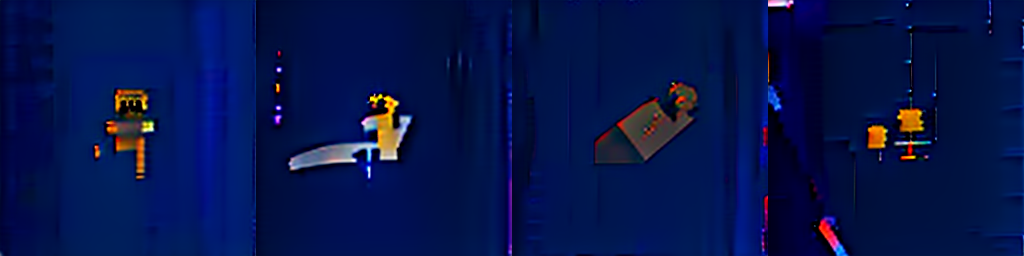

In [ ]:
""" V1 """
import torch
import torch
from diffusers import StableDiffusionPipeline, StableDiffusionImg2ImgPipeline, StableDiffusionInpaintPipelineLegacy, DDIMScheduler, AutoencoderKL
from PIL import Image
import sys
import os
sys.path.append(r'F:\Projects\diffusers\Project\PoseCtrl')
sys.path.append(r'F:\Projects\diffusers\Project\PoseCtrl\poseCtrl')
from poseCtrl.models.pose_adaptor import VPmatrixPoints, ImageProjModel
from poseCtrl.models.attention_processor import AttnProcessor, PoseAttnProcessor
from poseCtrl.data.dataset import CustomDataset, load_base_points
from poseCtrl.models.posectrl import PoseCtrl,PoseCtrlV1
import numpy as np


base_point_path=r'F:\Projects\diffusers\Project\PoseCtrl\dataSet\standardVertex.txt'
raw_base_points=load_base_points(base_point_path)  
base_model_path = r"F:\Projects\diffusers\ProgramData\basemodel"
vae_model_path = "stabilityai/sd-vae-ft-mse"
image_encoder_path = "laion/CLIP-ViT-H-14-laion2B-s32B-b79K"
ip_ckpt = r"F:\Projects\diffusers\Project\sd-pose_ctrl\V1\posectrl.bin"
path = r"F:\\Projects\\diffusers\\ProgramData\\sample_new"
device = "cuda"

def image_grid(imgs, rows, cols):
    assert len(imgs) == rows*cols

    w, h = imgs[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    grid_w, grid_h = grid.size
    
    for i, img in enumerate(imgs):
        grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid

noise_scheduler = DDIMScheduler(
    num_train_timesteps=1000,
    beta_start=0.00085,
    beta_end=0.012,
    beta_schedule="scaled_linear",
    clip_sample=False,
    set_alpha_to_one=False,
    steps_offset=1,
)
vae = AutoencoderKL.from_pretrained(vae_model_path).to(dtype=torch.float16)

# load SD pipeline
pipe = StableDiffusionImg2ImgPipeline.from_pretrained(
    base_model_path,
    torch_dtype=torch.float16,
    scheduler=noise_scheduler,
    vae=vae,
    feature_extractor=None,
    safety_checker=None
)


dataset = CustomDataset(path)
data = dataset[467]
from torchvision import transforms

transform = transforms.Resize((256, 256))


image = data['image']
image_pil = transforms.ToPILImage()(image)
image_pil = transform(image_pil) 

g_image = data['feature']
g_image_pil = transforms.ToPILImage()(g_image)
g_image_pil = transform(g_image_pil) 

vmatrix = data['view_matrix'].to(torch.float16).unsqueeze(0).to(device)
pmatrix = data['projection_matrix'].to(torch.float16).unsqueeze(0).to(device)

pose_model = PoseCtrlV1(pipe, image_encoder_path, ip_ckpt, raw_base_points, device)
images = pose_model.generate(pil_image=g_image_pil, num_samples=4, num_inference_steps=50, seed=37, image=image_pil, strength=0.6, V_matrix=vmatrix,P_matrix=pmatrix )
# images = pose_model.generate(pil_image=g_image, num_samples=4, num_inference_steps=50, seed=42, strength=0.6, V_matrix=vmatrix,P_matrix=pmatrix )
grid = image_grid(images, 1, 4)
grid

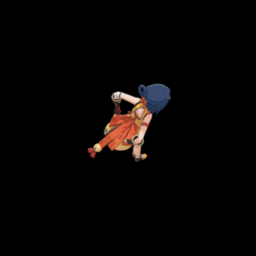

In [2]:
image_pil

# 6. inference T2I 先改sys.append再改路径

In [ ]:
""" V0 """
import torch
import torch
from diffusers import StableDiffusionPipeline, StableDiffusionImg2ImgPipeline, StableDiffusionInpaintPipelineLegacy, DDIMScheduler, AutoencoderKL
from PIL import Image
import sys
import os
sys.path.append(r'F:\Projects\diffusers\Project\PoseCtrl')
sys.path.append(r'F:\Projects\diffusers\Project\PoseCtrl\poseCtrl')
from poseCtrl.models.pose_adaptor import VPmatrixPoints, ImageProjModel
from poseCtrl.models.attention_processor import AttnProcessor, PoseAttnProcessor
from poseCtrl.data.dataset import CustomDataset, load_base_points
from poseCtrl.models.posectrl import PoseCtrl
import numpy as np


base_point_path=r'F:\Projects\diffusers\Project\PoseCtrl\dataSet\standardVertex.txt'
raw_base_points=load_base_points(base_point_path)  

base_model_path = r"F:\Projects\diffusers\ProgramData\basemodel"
vae_model_path = "stabilityai/sd-vae-ft-mse"
image_encoder_path = "laion/CLIP-ViT-H-14-laion2B-s32B-b79K"
ip_ckpt = r"F:\Projects\diffusers\Project\sd-pose_ctrl\trail_4\posectrl.bin"
device = "cuda"

def image_grid(imgs, rows, cols):
    assert len(imgs) == rows*cols

    w, h = imgs[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    grid_w, grid_h = grid.size
    
    for i, img in enumerate(imgs):
        grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid

noise_scheduler = DDIMScheduler(
    num_train_timesteps=1000,
    beta_start=0.00085,
    beta_end=0.012,
    beta_schedule="scaled_linear",
    clip_sample=False,
    set_alpha_to_one=False,
    steps_offset=1,
)
vae = AutoencoderKL.from_pretrained(vae_model_path).to(dtype=torch.float16)

# load SD pipeline
pipe = StableDiffusionPipeline.from_pretrained(
    base_model_path,
    torch_dtype=torch.float16,
    scheduler=noise_scheduler,
    vae=vae,
    feature_extractor=None,
    safety_checker=None
)
path = r"F:\\Projects\\diffusers\\ProgramData\\sample_new"
dataset = CustomDataset(path)
data = dataset[344]
from torchvision import transforms

transform = transforms.Resize((256, 256))


image = data['image']
image_pil = transforms.ToPILImage()(image)
image_pil = transform(image_pil)  

g_image = data['feature']
g_image_pil = transforms.ToPILImage()(g_image)
g_image_pil = transform(g_image_pil) 

vmatrix = data['view_matrix'].to(torch.float16).unsqueeze(0).to(device)
pmatrix = data['projection_matrix'].to(torch.float16).unsqueeze(0).to(device)

pose_model = PoseCtrl(pipe, image_encoder_path, ip_ckpt, raw_base_points, device)
# images = pose_model.generate(pil_image=g_image, num_samples=4, num_inference_steps=50, seed=42, image=image, strength=0.6, V_matrix=vmatrix,P_matrix=pmatrix )
images = pose_model.generate(pil_image=g_image, num_samples=4, num_inference_steps=100, seed=41, strength=0.6, V_matrix=vmatrix,P_matrix=pmatrix )
grid = image_grid(images, 1, 4)
grid


In [ ]:
!pip freeze > requirements.txt

In [4]:
!conda list --export > requirements.txt
